In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain_groq import ChatGroq
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph,END
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
llm=ChatGroq(model='gemma2-9b-it')

In [5]:
docs=TextLoader('research_notes.txt',encoding='utf-8').load()
chunks=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50).split_documents(docs)
vector_store=FAISS.from_documents(chunks,OpenAIEmbeddings(model='text-embedding-3-small'))
retriever=vector_store.as_retriever()

In [7]:
class IterativeRAGState(BaseModel):
    question:str
    refined_question:str=""
    retrieved_docs:List[Document]=[]
    answer:str=""
    verified:bool=False
    attempt:int=0


In [14]:
def retrieve_docs(state:IterativeRAGState)->IterativeRAGState:
    query=state.refined_question or state.question
    docs=retriever.invoke(query)
    return state.model_copy(update={'retrieved_docs':docs})

In [15]:
def generate_answer(state:IterativeRAGState) -> IterativeRAGState:
    context="\n\n".join(doc.page_content for doc in state.retrieved_docs)
    prompt=f"""Use the following context to answer the question:
    Context:{context}
    Question:{state.question}

    """

    response=llm.invoke(prompt.strip()).content.strip()
    return state.model_copy(update={'answer':response,'attempts':state.attempt+1})

In [16]:
def reflect_on_answer(state:IterativeRAGState) -> IterativeRAGState:
    prompt=f"""Evaluate whether the answer below is factually sufficient and complete
    question:{state.question}
    answer:{state.answer}
    Respond 'YES' if its complete,otherwise 'NO' with feedback."""

    feedback=llm.invoke(prompt).content.lower()
    verified='yes' in feedback
    return state.model_copy(update={'verified':verified})

In [17]:
def refine_query(state:IterativeRAGState) -> IterativeRAGState:
    prompt=f"""The answer appears incomplete,Suggest a better version of the query that would help retrieve more relevant context.
    original question:{state.question}
    current answer:{state.answer}"""

    new_query=llm.invoke(prompt).content.strip()
    return state.model(update={'refined_question':new_query})

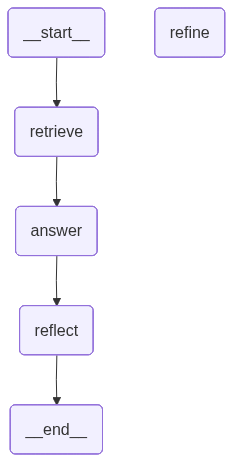

In [18]:
builder=StateGraph(IterativeRAGState)

builder.add_node('retrieve',retrieve_docs)
builder.add_node('answer',generate_answer)
builder.add_node('reflect',reflect_on_answer)
builder.add_node('refine',refine_query)

builder.set_entry_point('retrieve')
builder.add_edge('retrieve','answer')
builder.add_edge('answer','reflect')

builder.add_conditional_edges(
    'reflect',
    lambda s:END if s.verified or s.attempts >=2 else "refine"
)

builder.add_edge('refine','retrieve')
builder.add_edge('answer',END)

graph=builder.compile()

graph

In [20]:
if __name__=="__main__":
    query="what was dominated the sequence modeling before attention mechanism?"
    init_state=IterativeRAGState(question=query)
    result=graph.invoke(init_state)
    print(result)
    
    print("\nFinal Answer:",result['answer'])
    print("\nVerified",result['verified'])
    print('Attempts',result['attempt'])


{'question': 'what was dominated the sequence modeling before attention mechanism?', 'refined_question': '', 'retrieved_docs': [Document(id='1b340120-27f1-4a03-afb8-53034ed3ff52', metadata={'source': 'research_notes.txt'}, page_content='The introduction of the attention mechanism stands as one of the most significant milestones in modern artificial intelligence research.\nBefore attention, sequence modeling was dominated by recurrent neural networks (RNNs) and their gated variants such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU).\nWhile these models showed promise in processing temporal data like text and speech, they struggled with long-range dependencies.'), Document(id='bdaa9d5b-ab4c-4a09-b3e3-3d560e23c439', metadata={'source': 'research_notes.txt'}, page_content='Information from the start of a sequence often dissipated or was distorted by the time it reached the end, leading to degraded performance.\nAttention emerged as a solution, offering a way for models t